# PyTorch NN Workshop
### Introduction
Welcome to the PSIML's PyTorch Neural Networks Workshop. 
### Goal
In this workshop you will build a deep learning pipeline using PyTorch. You will use datasets and dataloaders to manipulate the data. You will learn how to make new models or change existing ones. You will make a 'training loop' to train, validate and test your model. 
### Key Ingredients
* Data
* Models
    * Logistic Regression as a single layer NN
    * Multi-layer NN
* Training and Testing

In [4]:
# some useful imports
import numpy as np
import torch
import torchvision
import pandas as pd
import PIL
import matplotlib.pyplot as plt

## Data
You have already learned how to make PyTorch datasets and dataloaders in previous workshop, so this time we will use some pre-made ones to speed things up.

Head out to [torchvision/datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) and check out the [Fashion-MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist) dataset.

This is a 'map style' dataset, therefore, `dataset[idx]` will return a sample at that index in form of a tuple (image, label) similar to the dataset example you saw in the PyTorch lecture.

You will notice that only train and test parts of the dataset are available. Therefore, we need to split the training part into train and validation. For this purpose it is useful to check the [SubsetRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler). Then, we will provide the train and valid split indices to create the corresponding samplers that we will pass to the train and valid dataloaders.

Note that if you wish to add some augmentations to your training dataset, you will need to create separate datasets. In the cell below, we create only the dummy transformations to convert our data into tensors. If you wish to play with data augmentations check [torchvision.transforms](https://pytorch.org/docs/stable/torchvision/transforms.html), however, it is optional and you can complete the workshop without any augmentations.

In [5]:
# data preprocessing and augmentations
# you can leave these as is for now (ToTensor just converts a PIL image to torch.tensor)
train_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])  # define your train transforms = augmentation + normalization
valid_test_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])  # define your validation/test transforms = usually just normalization

In [6]:
# get some datasets
train_dataset = torchvision.datasets.FashionMNIST('./data', train=True, transform=train_transforms, download=True)
valid_dataset = torchvision.datasets.FashionMNIST('./data', train=True, transform=valid_test_transforms, download=True)
    # note that we make the valid dataset using same data as for the train, but with different transformations.
    # we will later split the indices to form the actual training and validation datasets
test_dataset = torchvision.datasets.FashionMNIST('./data', train=False, transform=valid_test_transforms, download=True)

# get the labels of the dataset
label_descriptions = {i:train_dataset.classes[i] for i in range(len(train_dataset.classes))}
for L in label_descriptions:
    print(f'{L}: {label_descriptions[L]}')

0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


In [7]:
### COMPLETE THE CODE BELOW
# What are the dimensionalities of our dataset?
img_size = train_dataset[0][0].size()  # input dimensions
num_classes = len(label_descriptions)  # number of classes in our dataset

print(f'input dim: {img_size}   output dim: {num_classes}')

input dim: torch.Size([1, 28, 28])   output dim: 10


In [8]:
### COMPLETE THE CODE BELOW
# Split training dataset into training and test split and balance classes in both splits
# make train and valid splits

import random
random.seed(0)  # rng seed, set to 0 for reproducibility
train_dataset_indices = list(range(len(train_dataset)))

label_to_indices = dict()  # dictionary in which key is label and value is list of indices which belongs to that label

# initialize label_to_indices
for idx in range(len(label_descriptions)):
    label_to_indices[idx] = list()

for idx in range(len(train_dataset)):
    _, label = train_dataset[idx]
    label_to_indices[label].append(idx) 
    
valid_split_indices = []
validation_split_ratio = 0.2  # 20% of training instances 
# sample 20% instances for validation
for key in label_to_indices.keys():
    valid_split_indices.extend(np.random.choice(label_to_indices[key], 
                                                size=int(validation_split_ratio*len(label_to_indices[key])), 
                                                replace=False))

# remove validation instances from train split
train_split_indices = [idx for idx in train_dataset_indices if idx not in valid_split_indices]

In [10]:
# we can use SubsetRandomSampler to limit which indices our dataloader will use 
# (even though we are passing the same dataset to both of the dataloaders)
train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_split_indices)
valid_subset_sampler = torch.utils.data.SubsetRandomSampler(valid_split_indices)

# make dataloaders
batch_size = 1 
num_workers = 0 
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, sampler=valid_subset_sampler, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

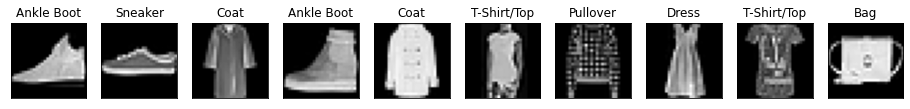

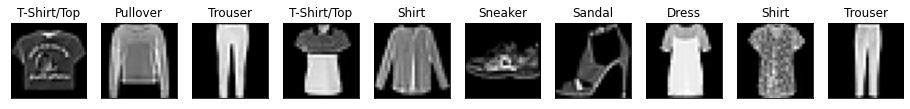

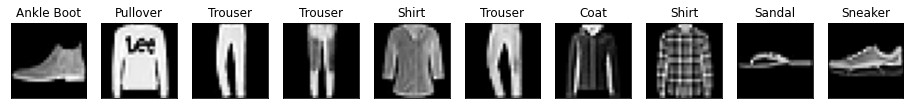

In [11]:
# lets visualize some data from our datasets

for dl in [train_dataloader, valid_dataloader, test_dataloader]:
    plt.figure(figsize=(16, 5))
    idl = iter(dl)  # so that we can call 'next'
    for i in range(10):
        image,label = next(idl)
        plt.subplot(1, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(label_descriptions[label.item()].title())
        plt.imshow(image.squeeze(), cmap='gray')
    plt.show()

## Models

### Logistic Regression as a single layer NN
In this section we will write the simple logistic regression model using available PyTorch functionalities.

First, take a look at https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression.

Therefore, we can use a [Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) model plus the [Cross Entropy Loss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) to define the multi-class logistic regression optimization problem.

PyTorch models are based on the [torch.nn.Module](https://pytorch.org/docs/master/generated/torch.nn.Module.html) class. It defines the model components ('\_\_init\_\_') and the operations applied to the input in terms of those components to get the output ('forward').

For example:
```Python
import torch.nn as nn
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = torch.nn.Linear(in_features=100, out_features=10, bias=True)
        self.layer2 = torch.nn.Linear(in_features=10, out_features=1, bias=True)

    def forward(self, x):
        x = F.sigmoid(self.layer1(x))
        x = self.layer2(x)
        return x
```

In [12]:
### COMPLETE THE CODE BELOW
# define a model class with a single linear layer with bias
# we do not need the softmax activation function since  
# the CELoss that we'll use later performs the softmax for us
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)  # rng for reproducibility

class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.layer1 = torch.nn.Linear(in_features=img_size[1]*img_size[2], 
                                      out_features=num_classes, bias=True)  # make a linear layer with bias; 
                                                                                 # input is the flattened image
                                                                                 # and we need 1 output per class
    def forward(self, x):
        x = self.layer1(x)
        return x

with torch.no_grad():
    image = torch.ones(28*28)
    model = LinearModel()
    print(model(image))

tensor([-0.0854, -0.3401,  0.2807, -0.2396, -0.8881, -0.3894, -0.1590,  0.3492,
         0.7761, -0.1154])


### Training loop
We will train a logistic regression model on Fashion-MNIST data, applying all the things we have learned so far. We will provide you with the code (similar to what you have seen in the logistic regression workshop) that you can imediately play with.

We will use the ready-made PyTorch dataset for Fashion-MNIST from the torchvision package.

Try playing with the following parameters and see if you can get better results or speed-up:
- learning_rate
- device (NOTE: you will need a gpu with cuda in order to play with this parameter)
- batch_size
- num_epochs
- num_workers

In [13]:
# Define the meta parameters of training

# create the model
model = LinearModel()  # our linear model

# create the SGD optimizer 
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # we will use stochastic gradient descent
    
# create the CrossEntropy Loss function
loss_func = nn.CrossEntropyLoss()  # we will use cross entropy loss

# make dataloaders
num_epochs = 2
batch_size = 1000 
num_workers = 0
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, 
                                               sampler=train_subset_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, 
                                               sampler=valid_subset_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, 
                                              shuffle=False, num_workers=num_workers)



In [24]:
### COMPLETE THE CODE BELOW
import time

dtype = torch.float
device = torch.device("cpu")  # change "cpu" to "cuda" to run on your GPU

# Training Loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # sets the model into training mode.
                   # (important if you use batch_norm, droupout and similar layers 
                   # that behave differently during training and during evaluation)
            
    for i, (x,y) in enumerate(train_dataloader):
        x = (x.reshape(x.size()[0], x.size()[1]*x.size()[2]*x.size()[3])).to(device)  # flatten 'x' and move it to device
        y = y.to(device)  # move 'y' to device

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call model parameters '.grad' will be the Tensors holding the gradient
        # of the loss with respect to w. Remember to zero out the gradients before each pass
        
        optimizer.zero_grad()  # zero the gradient buffers of the optimizer using .zero_grad()
        output = model(x)  # compute the model output (model() is equivalent to model.forward())
        loss = loss_func(output, y)  # compute the loss between the model output and the labels using the loss function
        loss.backward()  # compute the gradients of the loss using .backward()
        optimizer.step()  # Update the model weights via SGD (optimizer) using .step() 
        
        # Note that you can also manually update weights 
        # for f in model.parameters():
        #     f.data.sub_(f.grad.data * learning_rate)
        
        
        # print the loss
        if (i+1) % (6000//batch_size) == 0:
            print(f'epoch: {epoch}   iter: {i+1}   batch_loss: {loss}')       
    
    # Calculate validation accuracy
    correct = 0
    total = 0
    
    model.eval()  # sets the model into evaluation mode 
                  # (important if you use batch_norm, droupout and similar layers 
                  # that behave differently during training and during evaluation)
            
    with torch.no_grad(): # we don't need to track gradients during evaluation
        for x, y in valid_dataloader:
            x = (x.reshape(x.size()[0], x.size()[1]*x.size()[2]*x.size()[3])).to(device)  # flatten 'x' and move it to device
            y = y.to(device)  # move 'y' to device
            
            output = model(x)  # compute the model output (model() is equivalent to model.forward())
            
            y_pred = torch.softmax(output, 1)  # convert logits (model outputs) to class probabilities 
                           # (use torch.softmax or log_softmax)
            
            _, predicted = torch.max(y_pred, 1)  # find the most probable class (use torch.max)
            
            total+= y.size(0)
            correct+= (predicted == y).sum()
        validation_accuracy = 100 * float(correct)/total
        print(f'epoch: {epoch}   validation accuracy: {validation_accuracy}%' )
        
        
    # print epoch runtime
    end_time = time.time()
    print(f'--- Epoch completed in {end_time-start_time} seconds --- \n')

epoch: 0   iter: 6   batch_loss: 0.8188207745552063
epoch: 0   iter: 12   batch_loss: 0.7876473665237427
epoch: 0   iter: 18   batch_loss: 0.8180480003356934
epoch: 0   iter: 24   batch_loss: 0.7886351346969604
epoch: 0   iter: 30   batch_loss: 0.7820324301719666
epoch: 0   iter: 36   batch_loss: 0.7909149527549744
epoch: 0   iter: 42   batch_loss: 0.8114566206932068
epoch: 0   iter: 48   batch_loss: 0.7471509575843811
epoch: 0   validation accuracy: 74.65%
--- Epoch completed in 5.968367576599121 seconds --- 

epoch: 1   iter: 6   batch_loss: 0.8028846383094788
epoch: 1   iter: 12   batch_loss: 0.7764182686805725
epoch: 1   iter: 18   batch_loss: 0.7946919202804565
epoch: 1   iter: 24   batch_loss: 0.760504961013794
epoch: 1   iter: 30   batch_loss: 0.7923969626426697
epoch: 1   iter: 36   batch_loss: 0.8087417483329773
epoch: 1   iter: 42   batch_loss: 0.7815404534339905
epoch: 1   iter: 48   batch_loss: 0.7746831774711609
epoch: 1   validation accuracy: 75.13333333333334%
--- Epoch 

### Multi-layer NN

Now that you have familiarized yourself with the basic training pipeline, we will do some experiments with the model architecture

model (neural network) 
- you can see the Logistic Regression model as a single-layer neural network, now try adding more layers ([torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear))
- try different activation functions between the layers or at the output ([torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions))
- how does changing the final activation affect the loss function?
    
As above, try playing with the following parameters and see if you can get better results or speed-up:
- learning_rate (you can try different [optimizers](https://pytorch.org/docs/stable/optim.html) as well)
- device (NOTE: you will need a gpu with cuda in order to play with this parameter)
- batch_size
- num_epochs
- num_workers

In [27]:
### COMPLETE THE CODE BELOW
# define your model class

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layer1 = torch.nn.Linear(in_features=img_size[1]*img_size[2], 
                                      out_features=num_classes, bias=True)
        self.layer2 = torch.nn.Linear(in_features=num_classes, 
                                      out_features=num_classes, bias=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
    

In [30]:
### COMPLETE THE CODE BELOW
# Go ahead and make your own training pipeline following the code outline defined above.

# create the model
model = MyModel()  # instance your new model

# create the optimizer 
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # use SGD as above, or try something else, e.g. Adam
    
# create the CrossEntropy Loss function
loss_func = nn.CrossEntropyLoss()


# create transforms for data preprocessing and augmentations
train_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])  # you might add some augmentations and normalization
valid_test_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])  # define your validation/test transforms = usually just normalization

# get some datasets
train_dataset = torchvision.datasets.FashionMNIST('./data', train=True, transform=train_transforms, download=True)
valid_dataset = torchvision.datasets.FashionMNIST('./data', train=True, transform=valid_test_transforms, download=True)
test_dataset = torchvision.datasets.FashionMNIST('./data', train=False, transform=valid_test_transforms, download=True)

# make dataloaders
num_epochs = 10
batch_size = 1000
num_workers = 0

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, sampler=valid_subset_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [31]:
### COMPLETE THE CODE BELOW
# Copy the code from TL2 cell and train your best model.

import time

dtype = torch.float
device = torch.device("cpu")  # change "cpu" to "cuda" to run on your GPU

# Training Loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # sets the model into training mode.
                   # (important if you use batch_norm, droupout and similar layers 
                   # that behave differently during training and during evaluation)
            
    for i, (x,y) in enumerate(train_dataloader):
        x = (x.reshape(x.size()[0], x.size()[1]*x.size()[2]*x.size()[3])).to(device)  # flatten 'x' and move it to device
        y = y.to(device)  # move 'y' to device

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call model parameters '.grad' will be the Tensors holding the gradient
        # of the loss with respect to w. Remember to zero out the gradients before each pass
        
        optimizer.zero_grad()  # zero the gradient buffers of the optimizer using .zero_grad()
        output = model(x)  # compute the model output (model() is equivalent to model.forward())
        loss = loss_func(output, y)  # compute the loss between the model output and the labels using the loss function
        loss.backward()  # compute the gradients of the loss using .backward()
        optimizer.step()  # Update the model weights via SGD (optimizer) using .step() 
        
        # Note that you can also manually update weights 
        # for f in model.parameters():
        #     f.data.sub_(f.grad.data * learning_rate)
        
        
        # print the loss
        if (i+1) % (6000//batch_size) == 0:
            print(f'epoch: {epoch}   iter: {i+1}   batch_loss: {loss}')       
    
    # Calculate validation accuracy
    correct = 0
    total = 0
    
    model.eval()  # sets the model into evaluation mode 
                  # (important if you use batch_norm, droupout and similar layers 
                  # that behave differently during training and during evaluation)
            
    with torch.no_grad(): # we don't need to track gradients during evaluation
        for x, y in valid_dataloader:
            x = (x.reshape(x.size()[0], x.size()[1]*x.size()[2]*x.size()[3])).to(device)  # flatten 'x' and move it to device
            y = y.to(device)  # move 'y' to device
            
            output = model(x)  # compute the model output (model() is equivalent to model.forward())
            
            y_pred = torch.softmax(output, 1)  # convert logits (model outputs) to class probabilities 
                           # (use torch.softmax or log_softmax)
            
            _, predicted = torch.max(y_pred, 1)  # find the most probable class (use torch.max)
            
            total+= y.size(0)
            correct+= (predicted == y).sum()
        validation_accuracy = 100 * float(correct)/total
        print(f'epoch: {epoch}   validation accuracy: {validation_accuracy}%' )
        
        
    # print epoch runtime
    end_time = time.time()
    print(f'--- Epoch completed in {end_time-start_time} seconds --- \n')

epoch: 0   iter: 6   batch_loss: 2.309081554412842
epoch: 0   iter: 12   batch_loss: 2.245455503463745
epoch: 0   iter: 18   batch_loss: 2.1866486072540283
epoch: 0   iter: 24   batch_loss: 2.1506452560424805
epoch: 0   iter: 30   batch_loss: 2.1049726009368896
epoch: 0   iter: 36   batch_loss: 2.052292585372925
epoch: 0   iter: 42   batch_loss: 2.006887435913086
epoch: 0   iter: 48   batch_loss: 1.975480079650879
epoch: 0   validation accuracy: 39.24166666666667%
--- Epoch completed in 5.909937620162964 seconds --- 

epoch: 1   iter: 6   batch_loss: 1.9359500408172607
epoch: 1   iter: 12   batch_loss: 1.9071873426437378
epoch: 1   iter: 18   batch_loss: 1.8754578828811646
epoch: 1   iter: 24   batch_loss: 1.8370459079742432
epoch: 1   iter: 30   batch_loss: 1.7960933446884155
epoch: 1   iter: 36   batch_loss: 1.76121985912323
epoch: 1   iter: 42   batch_loss: 1.7250112295150757
epoch: 1   iter: 48   batch_loss: 1.7017433643341064
epoch: 1   validation accuracy: 50.766666666666666%
---

## The Competition
### Single fully connected model
Your task is to use the framework you wrote above to train the best possible model with the following constraints:
- single model only, no ensembles
- no convolutional or pooling layers (you can use dropout and/or batch norm)
- any activation functions
- any loss, any optimizer
- only 10 epochs allowed for training

Note: Remember that you can add augmentations to your training dataset and normalization to all datasets :)

Once you are satisfied with the achieved validation accuracy, continue below to compute the test accuracy.
Some scores on the FashionMNIST are provided below, however, most of these were trained for hundreds of epochs, and with a lot of augmentations so don't get discouraged if you dont beat all of them :)
- Human performance: 83.5%
- Logistic regression: 83.9%
- MLP (two layers): 87.4%
- MLP (four layers): 88.3%
- PSIML6 Competition Winner: 88.99
- ConvNet (2 layers only): 91.9%
- GoogLeNet: 93.7
- PSIML6 Competition Winner (no-limit): 94.29
- WideResNet with heay augmentations: 96.3% 
- Shake-Shake (SAM): 96.41

In [ ]:
### COMPLETE THE CODE BELOW
# Calculate test accuracy similarly to how you calculated the validation set accuracy

pass

test_accuracy = None

print(f'Final test accuracy: {test_accuracy}%' )